# Demo for PAO-ML via e3nn

See also https://docs.e3nn.org/en/latest/guide/convolution.html

## Requirements:
```
pip install --upgrade e3nn torch_cluster torch_scatter matplotlib
```

In [1]:
from pao_file_utils import parse_pao_file, write_pao_file, read_cp2k_energy
import torch
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
t = torch.tensor

In [2]:
# Convenient wrapper that returns torch Tensors
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]

In [3]:
# Load single training sample.
kinds, atom2kind, coords, xblocks = parse_pao_file_torch(Path("./2H2O_rotations/phi_00/2H2O_pao44-1_0.pao"))

In [4]:
TRAINING_KIND = "H" # The atom kinds for which we're training.
TRAINING_ATOMS = [i for i, kind in enumerate(atom2kind) if kind == TRAINING_KIND]
assert all(atom2kind[i]  == TRAINING_KIND for i in TRAINING_ATOMS)

In [5]:
# Irreps Input
#irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen
irreps_input = o3.Irreps("4x0e") # features: HH, OO, OH, HO
#irreps_input = o3.Irreps("6x0e") # feature: atom index as one hot !!! THIS IS A BIG HACK !!!

In [6]:
# Irreps Output
pao_basis_size = 4
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
prim_basis_spec = prim_basis_specs[TRAINING_KIND]
prim_basis_size = o3.Irreps(prim_basis_spec).dim
irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
for iatom in TRAINING_ATOMS:
    assert irreps_output.dim == xblocks[iatom].flatten().size(0)

In [7]:
# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=irreps_output.lmax)

48


(<Figure size 640x480 with 1 Axes>, <Axes: >)

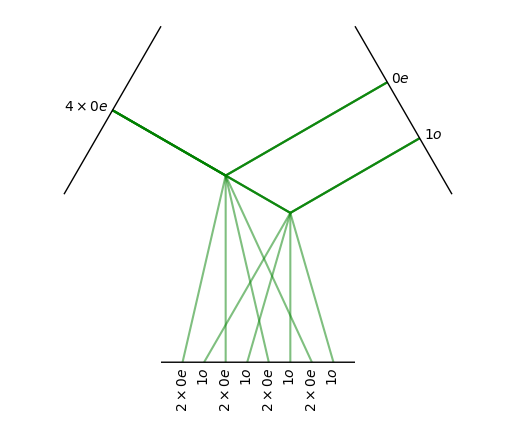

In [8]:
# Tensor Product
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
print(tp.weight_numel)
tp.visualize()

In [9]:
# Perceptron
num_distances = 10
num_layers = 16
# Note ReLu does not work well because many of the distance buckets from soft_one_hot_linspace are zero.
fc = nn.FullyConnectedNet([num_distances, num_layers, tp.weight_numel], torch.sigmoid) # relu does not 
print("Number of parameters: ", sum(p.numel() for p in fc.parameters()))

Number of parameters:  928


In [10]:
# The input of each node denotes the type direction as one-hot encoding.
num_directions = len(atom2kind) * len(atom2kind)

f_in = []
for ikind in atom2kind:
    for jkind in atom2kind:
        if ikind == "H" and jkind == "H":
            f_in.append([1., 0., 0, 0]) # Input is the position of neighboring Hydrogen.
        elif ikind == "O" and jkind == "O":
            f_in.append([0., 1., 0, 0])  # Input is the position of neighboring Oxygen.
        elif ikind == "O" and jkind == "H":
            f_in.append([0., 0., 1., 0]) # Input is cross-product of an Oxygen and a Hydrogen.
        elif ikind == "H" and jkind == "O":
            f_in.append([0., 0., 0., 1.])# Input is cross-product of a Hydrogen and an Oxygen.
        else:
            raise Exception("This should not happen")
        
f_in = t(f_in).mul(num_directions**0.5)
assert f_in.shape[0] == num_directions and f_in.shape[1] == irreps_input.dim

In [11]:
# CP2K uses the yzx convention, while e3nn uses xyz.
# https://docs.e3nn.org/en/stable/guide/change_of_basis.html
change_of_coord = torch.tensor([[0., 0., 1.],[1., 0., 0.],[0., 1., 0.]]) # yzx -> xyz
D = irreps_output.D_from_matrix(change_of_coord)

In [12]:
# Prepare model and loss function.
max_radius = 2 # Chosen such that the water molecules can't "see" each other.

def loss_function(pred, label):
    p1 = pred.T @ pred
    p2 = label.T @ label # is a projector because labels are orthonormal
    return (p1 - p2).pow(2).sum()

def model(dir_vec):
    sh = o3.spherical_harmonics(irreps_sh, dir_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(dir_vec.norm(dim=1), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    flat_xyz = tp(f_in, sh, fc(emb)).sum(dim=0).div(num_directions**0.5)
    flat_yzx = flat_xyz @ D
    return flat_yzx.reshape(pao_basis_size, prim_basis_size)

In [13]:
# Prepare features and labels.
def labelfy(xblock):
    # The loss_functions requires orthonormal labels.
    U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
    return Vh

labels = [labelfy(xblocks[i]) for i in TRAINING_ATOMS]

def directionify(edge_vecs):
    dir_vecs = []
    for i, vi in enumerate(edge_vecs):
        for j, vj in enumerate(edge_vecs):
            if i == j:
                dir_vecs.append(vi)
            else:
                dir_vecs.append(torch.cross(vi, vj))
    return torch.stack(dir_vecs)

dir_vecs = [directionify(coords - coords[i]) for i in TRAINING_ATOMS]

In [14]:
optim = torch.optim.Adam(fc.parameters())
num_steps= 30001
for step in range(num_steps):
    optim.zero_grad()
    loss_values = ""
    for dir_vec, label in zip(dir_vecs, labels):
        pred = model(dir_vec)
        loss = loss_function(pred, label)
        loss.backward()
        loss_values += (f"  {loss:.8e}")
    if step % 1000 == 0:
        print(f"training {step:5d} | loss {loss_values}")
    optim.step()

training     0 | loss   3.13916125e+05  3.08399375e+05  2.95506344e+05  3.25140812e+05
training  1000 | loss   1.55113663e+02  1.29208405e+02  1.04359879e+02  6.47771683e+01
training  2000 | loss   1.92545547e+01  1.55871696e+01  1.21340733e+01  1.38087759e+01
training  3000 | loss   5.20429659e+00  4.67762756e+00  3.72101831e+00  7.82689428e+00
training  4000 | loss   2.31037807e+00  2.45326686e+00  2.20902634e+00  5.30253315e+00
training  5000 | loss   1.49271083e+00  1.76583838e+00  1.91795385e+00  3.60593057e+00
training  6000 | loss   1.15843570e+00  1.44827640e+00  1.81410873e+00  2.40218377e+00
training  7000 | loss   8.74156594e-01  1.18856120e+00  1.35910976e+00  1.68576539e+00
training  8000 | loss   5.13404548e-01  9.39635515e-01  1.21068287e+00  1.32783175e+00
training  9000 | loss   3.55669111e-01  8.03181827e-01  1.21168017e+00  1.13598013e+00
training 10000 | loss   3.04267406e-01  6.71824515e-01  1.17663383e+00  1.01452827e+00
training 11000 | loss   3.19101751e-01  5.7

# Validation

In [15]:
# Test against rotated training samples using loss functions
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao"))[:10]:
    _, _, test_coords, test_xblocks = parse_pao_file_torch(path)
    for i in TRAINING_ATOMS:
        dir_vec = directionify(test_coords - test_coords[i])
        test_loss = loss_function(model(dir_vec), labelfy(test_xblocks[i]))
        print(f"{path}: atom: {i} lost: {test_loss:e}")

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 1 lost: 1.181423e-03
2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 2 lost: 6.501288e-04
2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 4 lost: 5.451898e-04
2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 5 lost: 2.524465e-04
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 1 lost: 1.250617e-04
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 2 lost: 5.953817e-04
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 4 lost: 2.633773e-04
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 5 lost: 2.034994e-04
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 1 lost: 1.607862e-03
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 2 lost: 1.265689e-03
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 4 lost: 2.306298e-04
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 5 lost: 9.823665e-04
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: atom: 1 lost: 2.010260e-04
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: atom: 2 lost: 6.297395e-04
2H2O_rotations/rand_

In [16]:
# Test against randomly rotated training samples using CP2K.
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao")):
    _, _, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    for i in TRAINING_ATOMS:
        dir_vec = directionify(sample_coords - sample_coords[i])
        pred_xblocks[i] = model(dir_vec)
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 ~/git/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: Relative Energy Diff: -8.552179e-08
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.672885e-08
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: Relative Energy Diff: -2.982104e-07
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: Relative Energy Diff: -4.244315e-08
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: Relative Energy Diff: -2.414339e-07
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.428918e-07
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.152437e-07
2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.923459e-07
2H2O_rotations/rand_08/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.855853e-07
2H2O_rotations/rand_09/2H2O_pao44-1_0.pao: Relative Energy Diff: -2.146635e-07
2H2O_rotations/rand_10/2H2O_pao44-1_0.pao: Relative Energy Diff: -6.232384e-08
2H2O_rotations/rand_11/2H2O_pao44-1_0.pao: Relative Energy Diff: -8.829114e-08
2H2O_rotations/rand_12/2H2O_pao44-1_0.pao: Relative 